<a href="https://colab.research.google.com/github/simonarahi/AI_HR/blob/master/candidate_screening.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading Libraries

In [1]:
import io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import sklearn

from sklearn import metrics
from sklearn import datasets, linear_model
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_classification
import statsmodels.formula.api as smf

from time import time

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.svm import SVC 
from sklearn.svm import LinearSVR
from sklearn.linear_model import Lasso, Ridge
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from pylab import rcParams
import seaborn as sb

from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Loading Data Set

In [2]:
from google.colab import files
uploaded = files.upload()

Saving HR_dataset.csv to HR_dataset.csv


In [3]:
HR = pd.read_csv(io.BytesIO(uploaded['HR_dataset.csv']))

In [4]:
HR.head()

,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,PayRate,Termd,PositionID,Position,State,Zip,DOB,Sex,MaritalDesc,CitizenDesc,HispanicLatino,RaceDesc,DateofHire,DateofTermination,TermReason,EmploymentStatus,Department,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30
0,"Brown, Mia",1.103024e+09,1.0,1.0,0.0,1.0,1.0,3.0,1.0,28.50,0.0,1.0,Accountant I,MA,1450.0,11/24/87,F,Married,US Citizen,No,Black or African American,10/27/2008,NaN,N/A - still employed,Active,Admin Offices,Brandon R. LeBlanc,1.0,Diversity Job Fair,Fully Meets,2.04,2.0,6.0,1/15/2019,0.0
1,"LaRotonda, William",1.106027e+09,0.0,2.0,1.0,1.0,1.0,3.0,0.0,23.00,0.0,1.0,Accountant I,MA,1460.0,04/26/84,M,Divorced,US Citizen,No,Black or African American,1/6/2014,NaN,N/A - still employed,Active,Admin Offices,Brandon R. LeBlanc,1.0,Website Banner Ads,Fully Meets,5.00,4.0,4.0,1/17/2019,0.0
2,"Steans, Tyrone",1.302053e+09,0.0,0.0,1.0,1.0,1.0,3.0,0.0,29.00,0.0,1.0,Accountant I,MA,2703.0,09/01/86,M,Single,US Citizen,No,White,9/29/2014,NaN,N/A - still employed,Active,Admin Offices,Brandon R. LeBlanc,1.0,Internet Search,Fully Meets,3.90,5.0,5.0,1/18/2019,0.0
3,"Howard, Estelle",1.211051e+09,1.0,1.0,0.0,1.0,1.0,3.0,0.0,21.50,1.0,2.0,Administrative Assistant,MA,2170.0,09/16/85,F,Married,US Citizen,No,White,2/16/2015,04/15/15,NaN,Terminated for Cause,Admin Offices,Brandon R. LeBlanc,1.0,Pay Per Click - Google,Fully Meets,3.24,3.0,4.0,NaN,NaN
4,"Singh, Nan",1.307060e+09,0.0,0.0,0.0,1.0,1.0,3.0,0.0,16.56,0.0,2.0,Administrative Assistant,MA,2330.0,05/19/88,F,Single,US Citizen,No,White,5/1/2015,NaN,N/A - still employed,Active,Admin Offices,Brandon R. LeBlanc,1.0,Website Banner Ads,Fully Meets,5.00,3.0,5.0,1/15/2019,0.0


## Data Exploration

In [5]:
HR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Employee_Name               310 non-null    object 
 1   EmpID                       310 non-null    float64
 2   MarriedID                   310 non-null    float64
 3   MaritalStatusID             310 non-null    float64
 4   GenderID                    310 non-null    float64
 5   EmpStatusID                 310 non-null    float64
 6   DeptID                      310 non-null    float64
 7   PerfScoreID                 310 non-null    float64
 8   FromDiversityJobFairID      310 non-null    float64
 9   PayRate                     310 non-null    float64
 10  Termd                       310 non-null    float64
 11  PositionID                  310 non-null    float64
 12  Position                    310 non-null    object 
 13  State                       310 non

In [6]:
# looking at columns we have
HR.columns

Index(['Employee_Name', 'EmpID', 'MarriedID', 'MaritalStatusID', 'GenderID',
       'EmpStatusID', 'DeptID', 'PerfScoreID', 'FromDiversityJobFairID',
       'PayRate', 'Termd', 'PositionID', 'Position', 'State', 'Zip', 'DOB',
       'Sex', 'MaritalDesc', 'CitizenDesc', 'HispanicLatino', 'RaceDesc',
       'DateofHire', 'DateofTermination', 'TermReason', 'EmploymentStatus',
       'Department', 'ManagerName', 'ManagerID', 'RecruitmentSource',
       'PerformanceScore', 'EngagementSurvey', 'EmpSatisfaction',
       'SpecialProjectsCount', 'LastPerformanceReview_Date', 'DaysLateLast30'],
      dtype='object')

Text(0, 0.5, 'Avg Pay Rate')

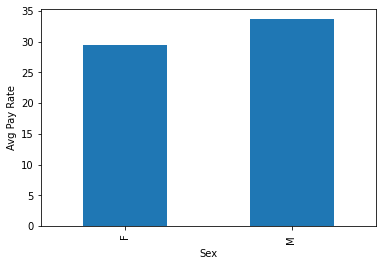

In [7]:
# looking at average payrates for each sex
plot1 = HR.groupby(['Sex']).mean().PayRate.plot(kind='bar')
plot1.set_ylabel("Avg Pay Rate")

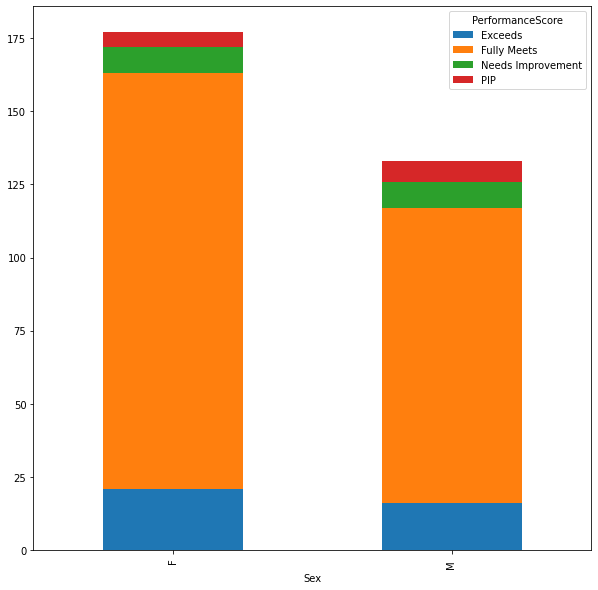

In [8]:
# looking at performance scores: M vs F
HR.groupby(['Sex', 'PerformanceScore']).size().unstack().plot(kind='bar', stacked=True, figsize=(10,10))


Text(0.5, 1.0, 'Missing values in the dataset')

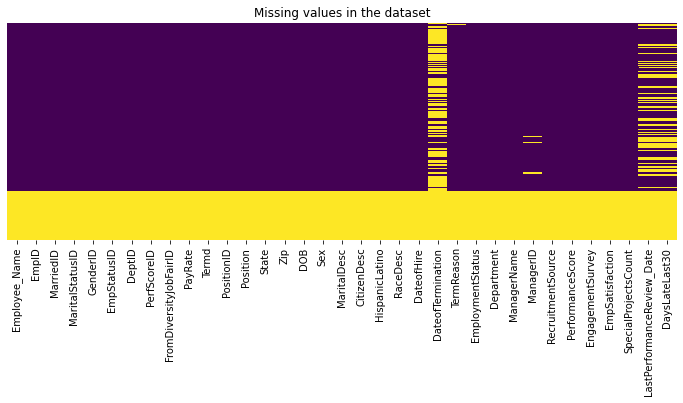

In [9]:
# plotting missing values
plt.figure(figsize=(12,4))
sns.heatmap(HR.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Missing values in the dataset')

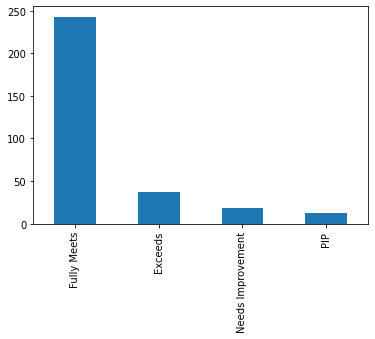

In [10]:
# counts of instances per class for Performance Score 
HR['PerformanceScore'].value_counts().plot(kind='bar')

In [11]:
# pairwise relationships with quantitative variables
HRquant = HR.filter(['PayRate','EngagementSurvey','EmpSatisfaction', 'SpecialProjectCounts'], axis=1)
HRquant.corr()

,PayRate,EngagementSurvey,EmpSatisfaction
PayRate,1.000000,-0.024223,0.061525
EngagementSurvey,-0.024223,1.000000,-0.017123
EmpSatisfaction,0.061525,-0.017123,1.000000


In [12]:
# calculating Shannon's entropy to ensure balance across classes
from scipy.stats import entropy
pd_series = pd.Series(HR['PerformanceScore'])
counts = pd_series.value_counts()
entropy = entropy(counts)
balance = entropy/np.log(4)

print(entropy)
print(balance)

0.7357224105786224
0.5307115366063262


# Models

In this second method, I will choose different features to predict the performance score of employees. This will be a multiclass classification problem.

In [13]:
HR = pd.read_csv(io.BytesIO(uploaded['HR_dataset.csv']))

### Preprocessing

In [14]:
HR.drop(columns=['GenderID', 'Employee_Name', 'EmpID', 'MarriedID', 'MaritalStatusID', 'EmpStatusID' ,
                 'DeptID', 'PositionID', 'DOB','State', 'Zip', 'CitizenDesc', 
                 'HispanicLatino', 'DateofHire', 'DateofTermination', 'TermReason', 
                 'ManagerName', 'ManagerID', 'LastPerformanceReview_Date', 'DaysLateLast30', 'PerformanceScore'], inplace=True)

In [15]:
HR.info()
HR.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PerfScoreID             310 non-null    float64
 1   FromDiversityJobFairID  310 non-null    float64
 2   PayRate                 310 non-null    float64
 3   Termd                   310 non-null    float64
 4   Position                310 non-null    object 
 5   Sex                     310 non-null    object 
 6   MaritalDesc             310 non-null    object 
 7   RaceDesc                310 non-null    object 
 8   EmploymentStatus        310 non-null    object 
 9   Department              310 non-null    object 
 10  RecruitmentSource       310 non-null    object 
 11  EngagementSurvey        310 non-null    float64
 12  EmpSatisfaction         310 non-null    float64
 13  SpecialProjectsCount    310 non-null    float64
dtypes: float64(7), object(7)
memory usage: 44.

In [16]:
# encoding our categorical nominal variables 
HR1 = pd.get_dummies(HR, columns=['Sex', 'Position', 'MaritalDesc', 'RaceDesc',
                                 'EmploymentStatus', 'Department', 'RecruitmentSource'])
HR1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310 entries, 0 to 309
Data columns (total 86 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   PerfScoreID                                               310 non-null    float64
 1   FromDiversityJobFairID                                    310 non-null    float64
 2   PayRate                                                   310 non-null    float64
 3   Termd                                                     310 non-null    float64
 4   EngagementSurvey                                          310 non-null    float64
 5   EmpSatisfaction                                           310 non-null    float64
 6   SpecialProjectsCount                                      310 non-null    float64
 7   Sex_F                                                     310 non-null    uint8  
 8   Sex_M               

In [17]:
# selecting features columns (x) and response (y)
x = HR1.iloc[:,1:].values
Y = HR1.iloc[:, 0].values
print(x.shape)
print(Y.shape)

(310, 85)
(310,)


In [18]:
# splitting data into test (25%) and train (75%)
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size=0.25, random_state=0)

Our response variable is PerfScoreID. It is an ordinal variable with 4 levels: 1 refers to PIP, 2 needs improvement, 3 fully meets, and 4 exceeds.

In [19]:
# handling imbalanced classes by oversampling minority class
smote = SMOTE('minority')

x_sm, Y_sm = smote.fit_sample(x_train, Y_train)
print(x_sm.shape, Y_sm.shape)

(404, 85) (404,)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [20]:
# scaling features due to different in units
from sklearn.preprocessing import StandardScaler
ss_X = StandardScaler()
ss_x_train = ss_X.fit_transform(x_sm)
ss_x_test = ss_X.transform(x_test)

## Random Forest

In [21]:
rf = RandomForestClassifier(n_estimators=10, criterion="entropy", random_state=0)
#rf.fit(x_sm, Y_sm)
rf.fit(ss_x_train, Y_sm)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [22]:
# predictions
#rf_pred = rf.predict(x_test)
rf_pred = rf.predict(ss_x_test)

Accuracy score: 0.8205128205128205
Precision score: 0.8205128205128205
Recall score: 0.8205128205128205


Text(91.68, 0.5, 'Predicted Values')

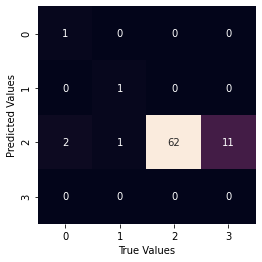

In [23]:
rf_accuracy = metrics.accuracy_score(Y_test, rf_pred) 
print("Accuracy score:",rf_accuracy)
precision = metrics.precision_score(Y_test, rf_pred, average='micro') 
print("Precision score:",precision)
recall = metrics.recall_score(Y_test, rf_pred, average='micro') 
print("Recall score:",recall)

mat = confusion_matrix(Y_test,rf_pred)
sns.heatmap(mat.T, square =True, annot = True, fmt = 'd', cbar= False)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

## Naive Bayes

In [24]:
#gnb = GaussianNB().fit(x_sm, Y_sm)
gnb = GaussianNB().fit(ss_x_train, Y_sm)

In [25]:
#gnb_predictions = gnb.predict(x_test)
gnb_predictions = gnb.predict(ss_x_test)

Accuracy Score: 0.28205128205128205


Text(91.68, 0.5, 'Predicted Values')

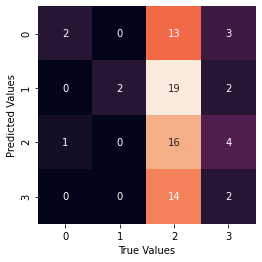

In [26]:
print('Accuracy Score:', accuracy_score(Y_test, gnb_predictions))
mat = confusion_matrix(Y_test,gnb_predictions)
sns.heatmap(mat.T, square =True, annot = True, fmt = 'd', cbar= False)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

## SVM

In [27]:
#svm_model_linear = SVC(kernel = 'linear', C = 1).fit(x_sm, Y_sm) 
#svm_predictions = svm_model_linear.predict(x_test) 
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(ss_x_train, Y_sm) 
svm_predictions = svm_model_linear.predict(ss_x_test) 

# model accuracy  
svm_accuracy = svm_model_linear.score(ss_x_test, Y_test) 
  
# creating a confusion matrix 
cm = confusion_matrix(Y_test, svm_predictions)

Accuracy Score: 0.717948717948718


Text(91.68, 0.5, 'Predicted Values')

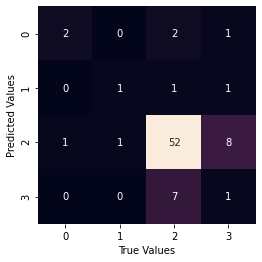

In [28]:
print('Accuracy Score:', svm_accuracy)
mat = confusion_matrix(Y_test,svm_predictions)
sns.heatmap(mat.T, square =True, annot = True, fmt = 'd', cbar= False)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

## kNN

Text(0, 0.5, 'Testing Accuracy')

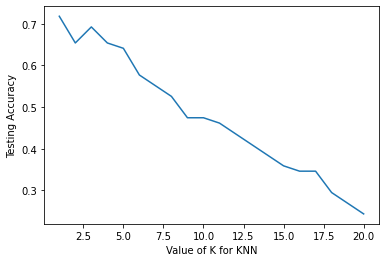

In [29]:
# to check which k gives the highest accuracy
k_range = range(1,21)
scores = {}
scores_list = []
for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(ss_x_train, Y_sm)
  knn_pred=knn.predict(ss_x_test)
  scores[k] = metrics.accuracy_score(Y_test, knn_pred)
  scores_list.append(metrics.accuracy_score(Y_test, knn_pred))


plt.plot(k_range, scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [30]:
 knn = KNeighborsClassifier(n_neighbors = 1).fit(ss_x_train, Y_sm)

Accuracy Score: 0.717948717948718


Text(91.68, 0.5, 'Predicted Values')

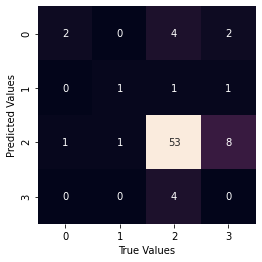

In [31]:
knn_accuracy = knn.score(ss_x_test, Y_test)
knn_predictions = knn.predict(ss_x_test)  
print('Accuracy Score:', knn_accuracy)
mat = confusion_matrix(Y_test,knn_predictions)
sns.heatmap(mat.T, square =True, annot = True, fmt = 'd', cbar= False)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

## Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
logistic_classifier = LogisticRegression(random_state=0, solver="liblinear")
logistic_classifier.fit(ss_x_train, Y_sm)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
logistic_pred = logistic_classifier.predict(ss_x_test)

Accuracy: 0.7307692307692307
Precision score: 0.3480392156862745
Recall score: 0.4301075268817204


Text(91.68, 0.5, 'Predicted Values')

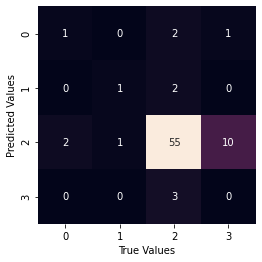

In [35]:
logistic_accuracy = metrics.accuracy_score(Y_test, logistic_pred) 
print("Accuracy:",logistic_accuracy)
precision = metrics.precision_score(Y_test, logistic_pred, average='macro') 
print("Precision score:",precision)
recall = metrics.recall_score(Y_test, logistic_pred, average='macro') 
print("Recall score:",recall)

mat = confusion_matrix(Y_test,logistic_pred)
sns.heatmap(mat.T, square =True, annot = True, fmt = 'd', cbar= False)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# Comparison of Performances Across Models

In [36]:
comparisons = {'Classifier':  ['Random Forest', 'Naive Bayes', 'Support Vector Machine', 'k-Nearest Neighbor', 'Logistic Regression'],
        'Accuracy': [rf_accuracy, accuracy_score(Y_test, gnb_predictions), svm_accuracy, knn_accuracy, logistic_accuracy]
        }

df = pd.DataFrame(comparisons, columns = ['Classifier','Accuracy'])
df

,Classifier,Accuracy
0,Random Forest,0.820513
1,Naive Bayes,0.282051
2,Support Vector Machine,0.717949
3,k-Nearest Neighbor,0.717949
4,Logistic Regression,0.730769
